# 量子回路の最適化

<Admonition type="note">
  Toshinari Itoko (21 June 2024), Translated by Daiki Murata

  [元の講義のPDFをダウンロード](https://ibm.box.com/shared/static/0hvvgr1gnwx64x2ukgk04sss6sxc4zko.zip)できます。
  *この実験をQPUで実行するのに必要なおおよその時間は15秒です。*

  （注：パート2の一部セルは "Qiskit Deep dive" ノートブックから引用しています。著者は Matthew Treinish（Qiskit管理者）です）
</Admonition>



In [1]:
!pip install 'qiskit[visualization]'
!pip install qiskit_ibm_runtime qiskit_aer
!pip install jupyter
!pip install matplotlib pylatexenc pydot pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/62.0 kB ? eta -:--:--Collecting scipy>=1.5 (from qiskit[visualization])
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ...   Downloading pylatexenc-2.10.tar.gz (162 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/108.9 kB ? eta -:--:--Collecting fonttools>=4.22.0 (from matplotlib>=3.3->qiskit[visualization])
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import qiskit

qiskit.__version__

'2.1.1'

In [3]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.__version__

'0.41.0'

In [4]:
import qiskit_aer

qiskit_aer.__version__

'0.17.1'

## 1. はじめに

このレッスンでは、量子コンピューティングにおける回路最適化のさまざまな側面について説明します。まず、Qiskitに組み込まれている最適化設定を使って回路最適化の価値を確認します。次に、特定の応用分野の専門家として、賢く回路を構築する方法を少し掘り下げて学びます。最後に、トランスパイル時に回路がどのように最適化されるかを詳しく見ていきます。



## 2. 回路最適化の重要性

まず、最適化あり・なしで5量子ビットGHZ状態（$\frac{1}{\sqrt{2}} \left( |00000\rangle + |11111\rangle \right)$）生成回路の実行結果を比較します。



In [5]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendSamplerV2 as Sampler

In [6]:
from qiskit_ibm_runtime.fake_provider import FakeKyiv

backend = FakeKyiv()

まず、以下のように素朴に合成したGHZ回路を使います。



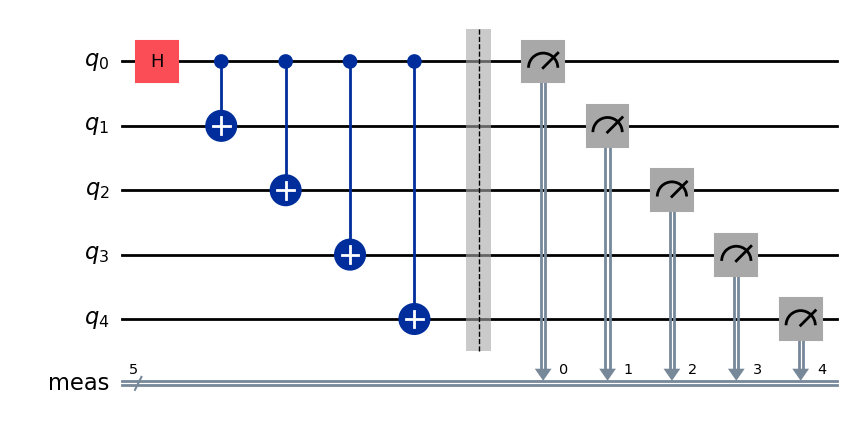

In [7]:
num_qubits = 5

ghz_circ = QuantumCircuit(num_qubits)
ghz_circ.h(0)
[ghz_circ.cx(0, i) for i in range(1, num_qubits)]
ghz_circ.measure_all()
ghz_circ.draw("mpl")

### 2.1 最適化レベル

最適化レベル `optimization_level` は 0〜3 の4段階があります。最適化レベルが高いほど、回路最適化により多くの計算リソースが使われます。レベル0は最適化を行わず、選択したバックエンドで回路を実行可能にするための最低限の処理のみ行います。レベル3は最も多くの労力（通常は実行時間も長い）をかけて回路を最適化します。レベル1がデフォルトです。



回路を最適化なし（`optimization_level=0`）と最適化あり（`optimization_level=2`）でトランスパイルします。
トランスパイル後の回路長に大きな違いがあることが分かります。



optimization_level=0:


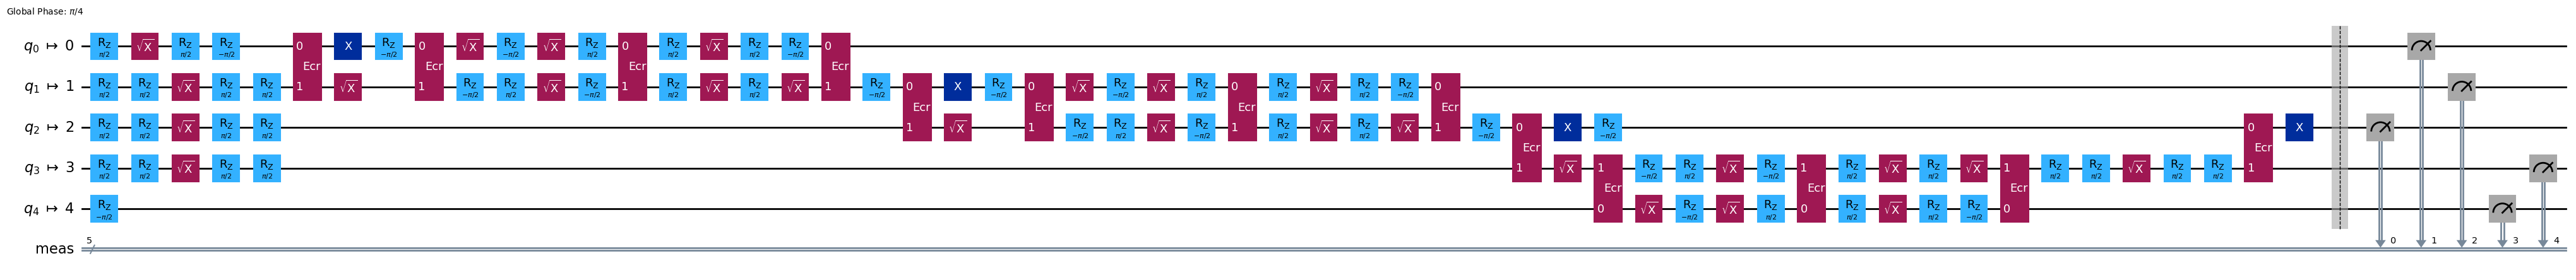

optimization_level=2:


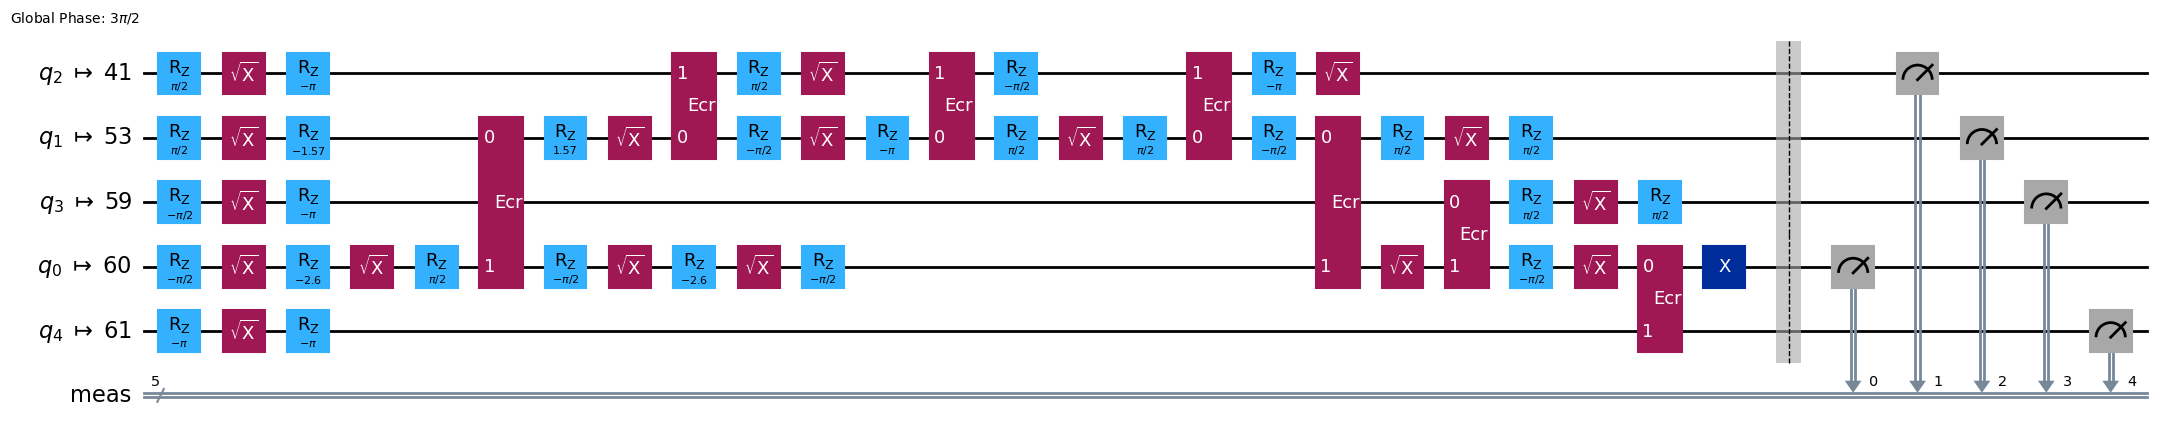

In [8]:
pm0 = generate_preset_pass_manager(
    optimization_level=0, backend=backend, seed_transpiler=777
)
pm2 = generate_preset_pass_manager(
    optimization_level=2, backend=backend, seed_transpiler=777
)
circ0 = pm0.run(ghz_circ)
circ2 = pm2.run(ghz_circ)
print("optimization_level=0:")
display(circ0.draw("mpl", idle_wires=False, fold=-1))
print("optimization_level=2:")
display(circ2.draw("mpl", idle_wires=False, fold=-1))

### 2.2 演習

`optimization_level=1`も試して、上記2つと結果を比較してください。上のコードを修正して試してみましょう。

**解答例:**



optimization_level=1:


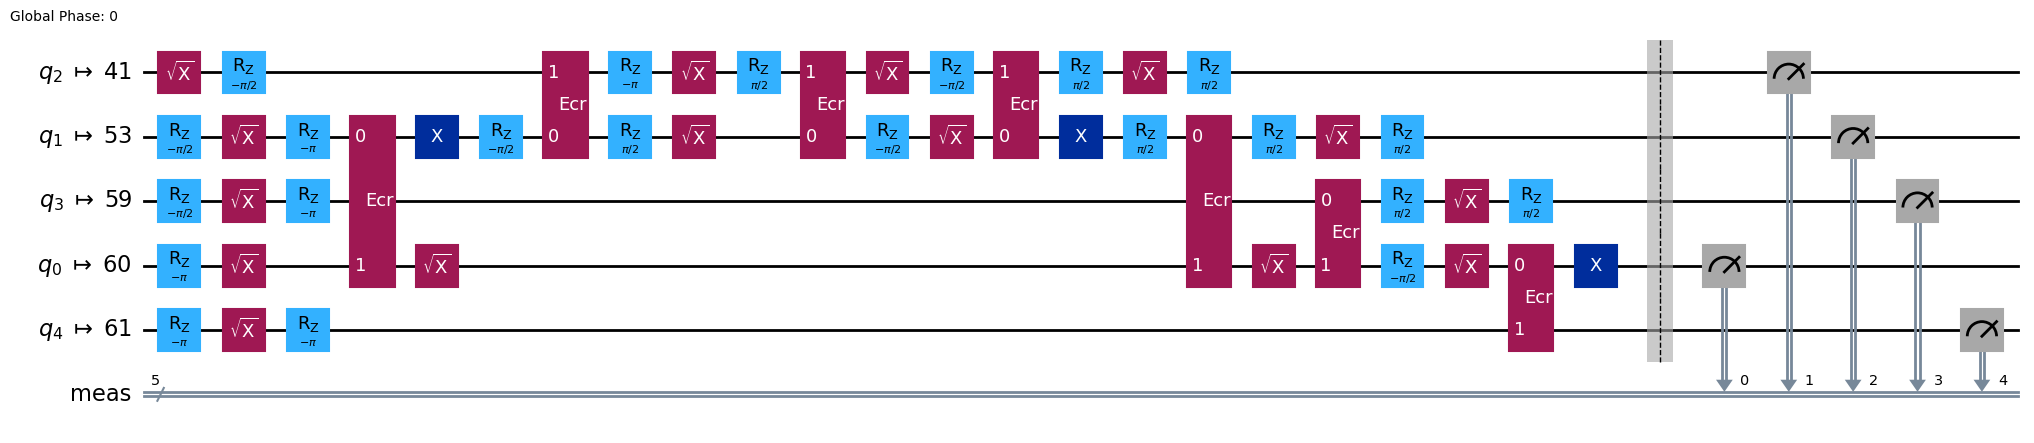

In [9]:
pm1 = generate_preset_pass_manager(
    optimization_level=1, backend=backend, seed_transpiler=777
)
circ1 = pm1.run(ghz_circ)
print("optimization_level=1:")
display(circ1.draw("mpl", idle_wires=False, fold=-1))

フェイクバックエンド（ノイズ付きシミュレーター）で実行します。実機での実行方法は付録1を参照してください。



In [10]:
# run the circuits on the fake backend (noisy simulator)
sampler = Sampler(backend=backend)
job = sampler.run([circ0, circ2], shots=10000)
print(f"Job ID: {job.job_id()}")

Job ID: d510d781-b2a0-450e-904a-540a618373b0


In [11]:
# get results
result = job.result()
unoptimized_result = result[0].data.meas.get_counts()
optimized_result = result[1].data.meas.get_counts()

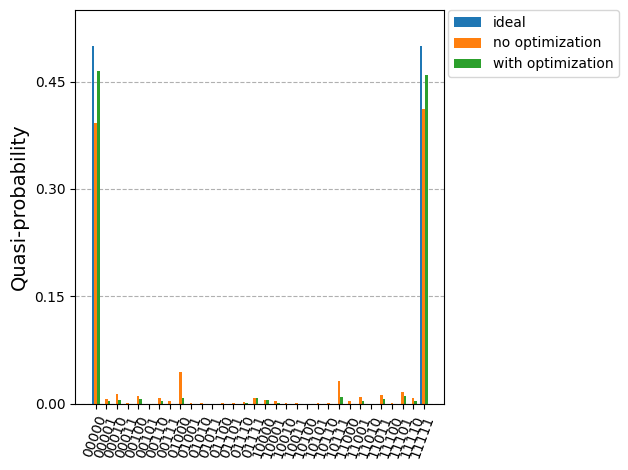

In [12]:
from qiskit.visualization import plot_histogram

# plot
sim_result = {"0" * 5: 0.5, "1" * 5: 0.5}
plot_histogram(
    [result for result in [sim_result, unoptimized_result, optimized_result]],
    bar_labels=False,
    legend=[
        "ideal",
        "no optimization",
        "with optimization",
    ],
)

## 3. 回路合成の重要性



次に、2通りの合成方法で作った5量子ビットGHZ状態（$\frac{1}{\sqrt{2}} \left( |00000\rangle + |11111\rangle \right)$）生成回路の実行結果を比較します。



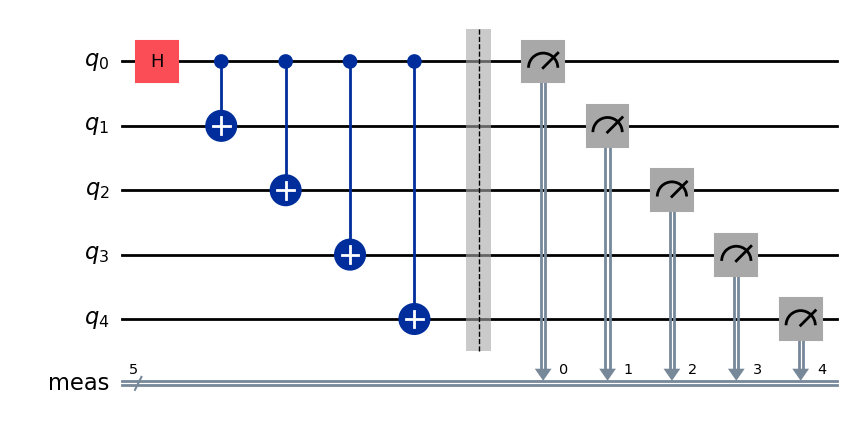

In [13]:
# Original GHZ circuit (naive synthesis)
ghz_circ.draw("mpl")

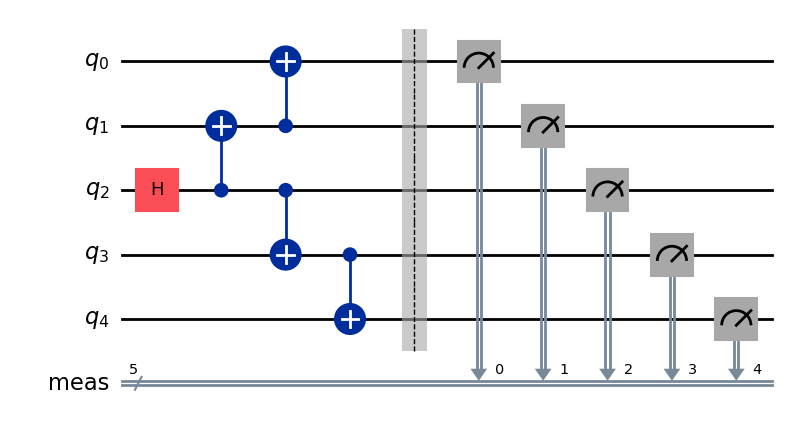

In [14]:
# A cleverly-synthesized GHZ circuit
ghz_circ2 = QuantumCircuit(5)
ghz_circ2.h(2)
ghz_circ2.cx(2, 1)
ghz_circ2.cx(2, 3)
ghz_circ2.cx(1, 0)
ghz_circ2.cx(3, 4)
ghz_circ2.measure_all()
ghz_circ2.draw("mpl")

original synthesis:


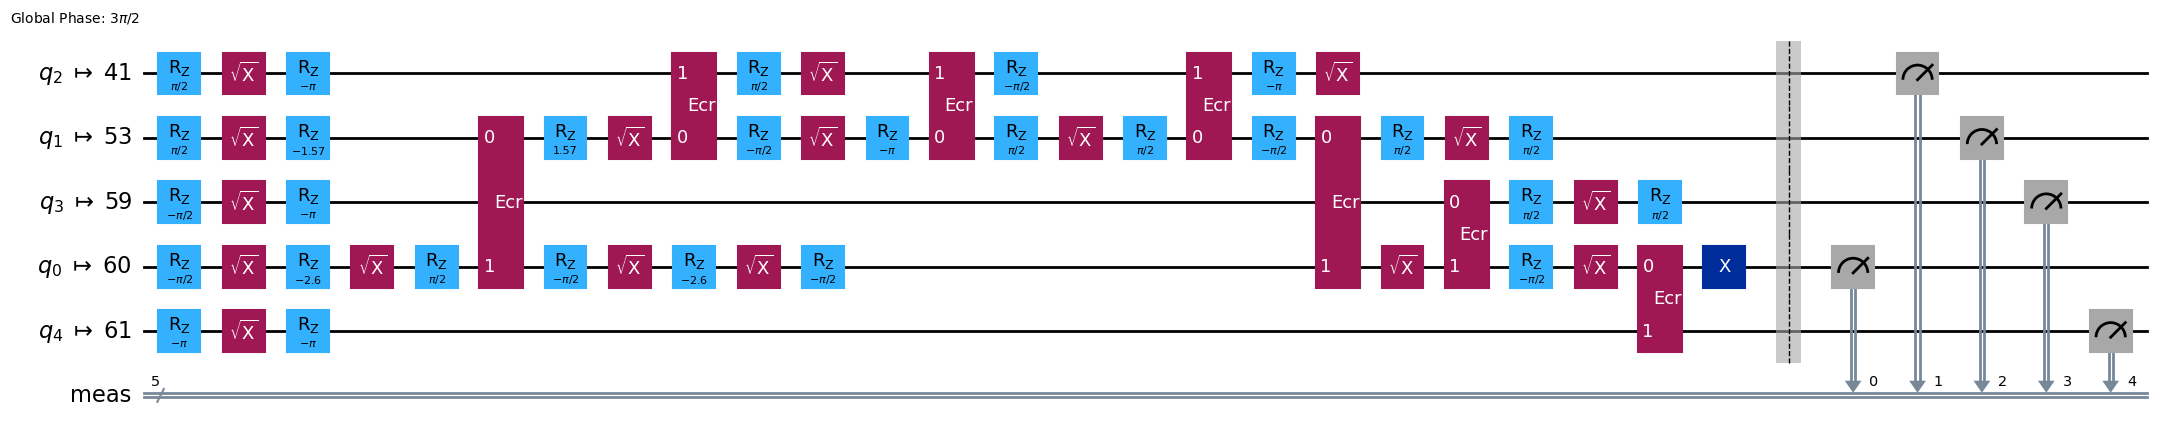

new synthesis:


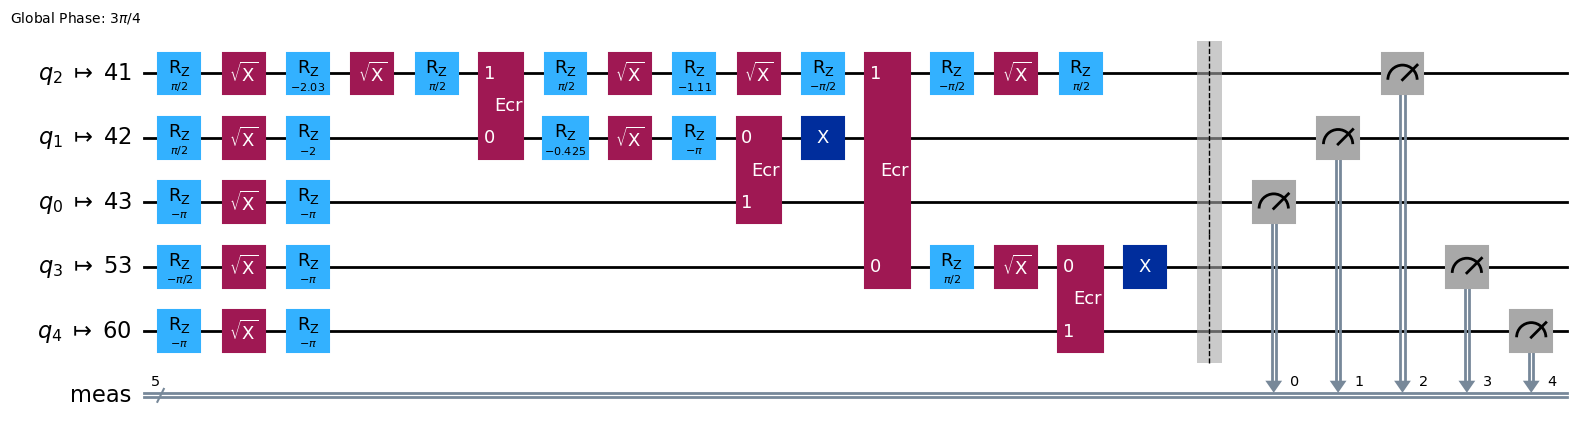

In [15]:
# transpile both with the same optimization level 2
circ_org = pm2.run(ghz_circ)
circ_new = pm2.run(ghz_circ2)
print("original synthesis:")
display(circ_org.draw("mpl", idle_wires=False, fold=-1))
print("new synthesis:")
display(circ_new.draw("mpl", idle_wires=False, fold=-1))

新しい合成方法では、より浅い回路が得られます。なぜでしょうか？

新しい回路は線形に接続された量子ビット上に配置できるため、IBM® Kyivのheavy-hexagon結合グラフでも配置可能です。一方、元の回路は星型（次数4のノード）接続が必要で、heavy-hex結合グラフ（最大次数3）には直接配置できません。そのため、元の回路ではSWAPゲートによるルーティングが必要となり、ゲート数が増加します。

新しい回路合成は「結合制約を考慮した回路合成」を手動で行った例です。つまり、回路合成と回路マッピングを同時に手動で解決しています。



In [16]:
# run the circuits
sampler = Sampler(backend=backend)
job = sampler.run([circ_org, circ_new], shots=10000)
print(f"Job ID: {job.job_id()}")

Job ID: 0cbb94c5-9202-44e5-a6e3-a8a7ce31b440


In [17]:
# get results
result = job.result()
synthesis_org_result = result[0].data.meas.get_counts()
synthesis_new_result = result[1].data.meas.get_counts()

In [18]:
# plot
sim_result = {"0" * 5: 0.5, "1" * 5: 0.5}
plot_histogram(
    [
        result
        for result in [
            sim_result,
            unoptimized_result,
            synthesis_org_result,
            synthesis_new_result,
        ]
    ],
    bar_labels=False,
    legend=[
        "ideal",
        "no optimization",
        "synthesis_org",
        "synthesis_new",
    ],
)

一般に、回路合成はアプリケーションによって異なり、すべてのアプリケーションをソフトウェアでカバーするのは困難です。QiskitのトランスパイラにはGHZ状態生成回路の合成機能はありません。このような場合、上記のような手動回路合成が有効です。

このセクションでは、Qiskitトランスパイラがどのように動作するかを、以下のおもちゃの回路例を使って詳しく見ていきます。



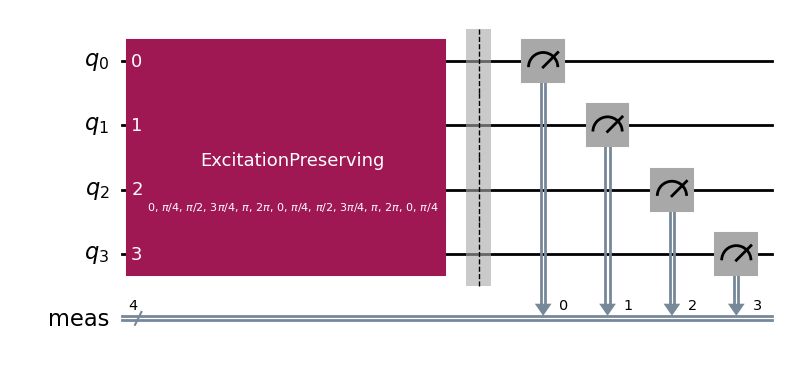

In [20]:
# Build a toy example circuit
from math import pi
import itertools
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import excitation_preserving

circuit = QuantumCircuit(4, name="Example circuit")
circuit.append(excitation_preserving(4, reps=1), range(4))
circuit.measure_all()

value_cycle = itertools.cycle([0, pi / 4, pi / 2, 3 * pi / 4, pi, 2 * pi])
circuit.assign_parameters(
    [x[1] for x in zip(range(len(circuit.parameters)), value_cycle)], inplace=True
)
circuit.draw("mpl")

### 3.1 Qiskitトランスパイル全体の流れを描画



`optimization_level=1`のトランスパイラパス（タスク）を見ていきます。



In [21]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# There is no need to read this entire image, but this outputs all the steps in the transpile() call
# for optimization level 1
pm = generate_preset_pass_manager(1, backend, seed_transpiler=42)
pm.draw()

フローは6つのステージで構成されています：



In [22]:
print(pm.stages)

('init', 'layout', 'routing', 'translation', 'optimization', 'scheduling')


### 3.2 個別ステージの描画

まず、`init`ステージで実行されるすべてのタスク（トランスパイラパス）を描画します。



In [23]:
pm.init.draw()

各ステージは個別に実行できます。`init`ステージを回路に対して実行してみましょう。ロガーを有効にすると、実行の詳細が表示されます。



INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.16689 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.06390 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.24319 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContractIdleWiresInControlFlow - 0.00691 (ms)


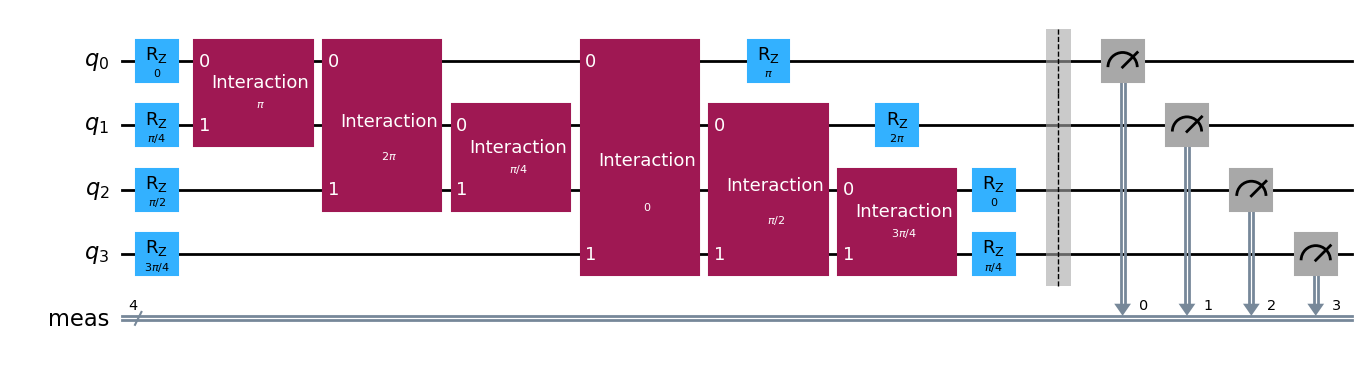

In [24]:
import logging

logger = logging.getLogger()
logger.setLevel("INFO")

init_out = pm.init.run(circuit)
init_out.draw("mpl", fold=-1)

### 3.3 演習

`layout`ステージのパスを描画し、`init`ステージの出力回路（`init_out`）に対してステージを実行してください。上記セルを修正して実施します。

**解答例:**



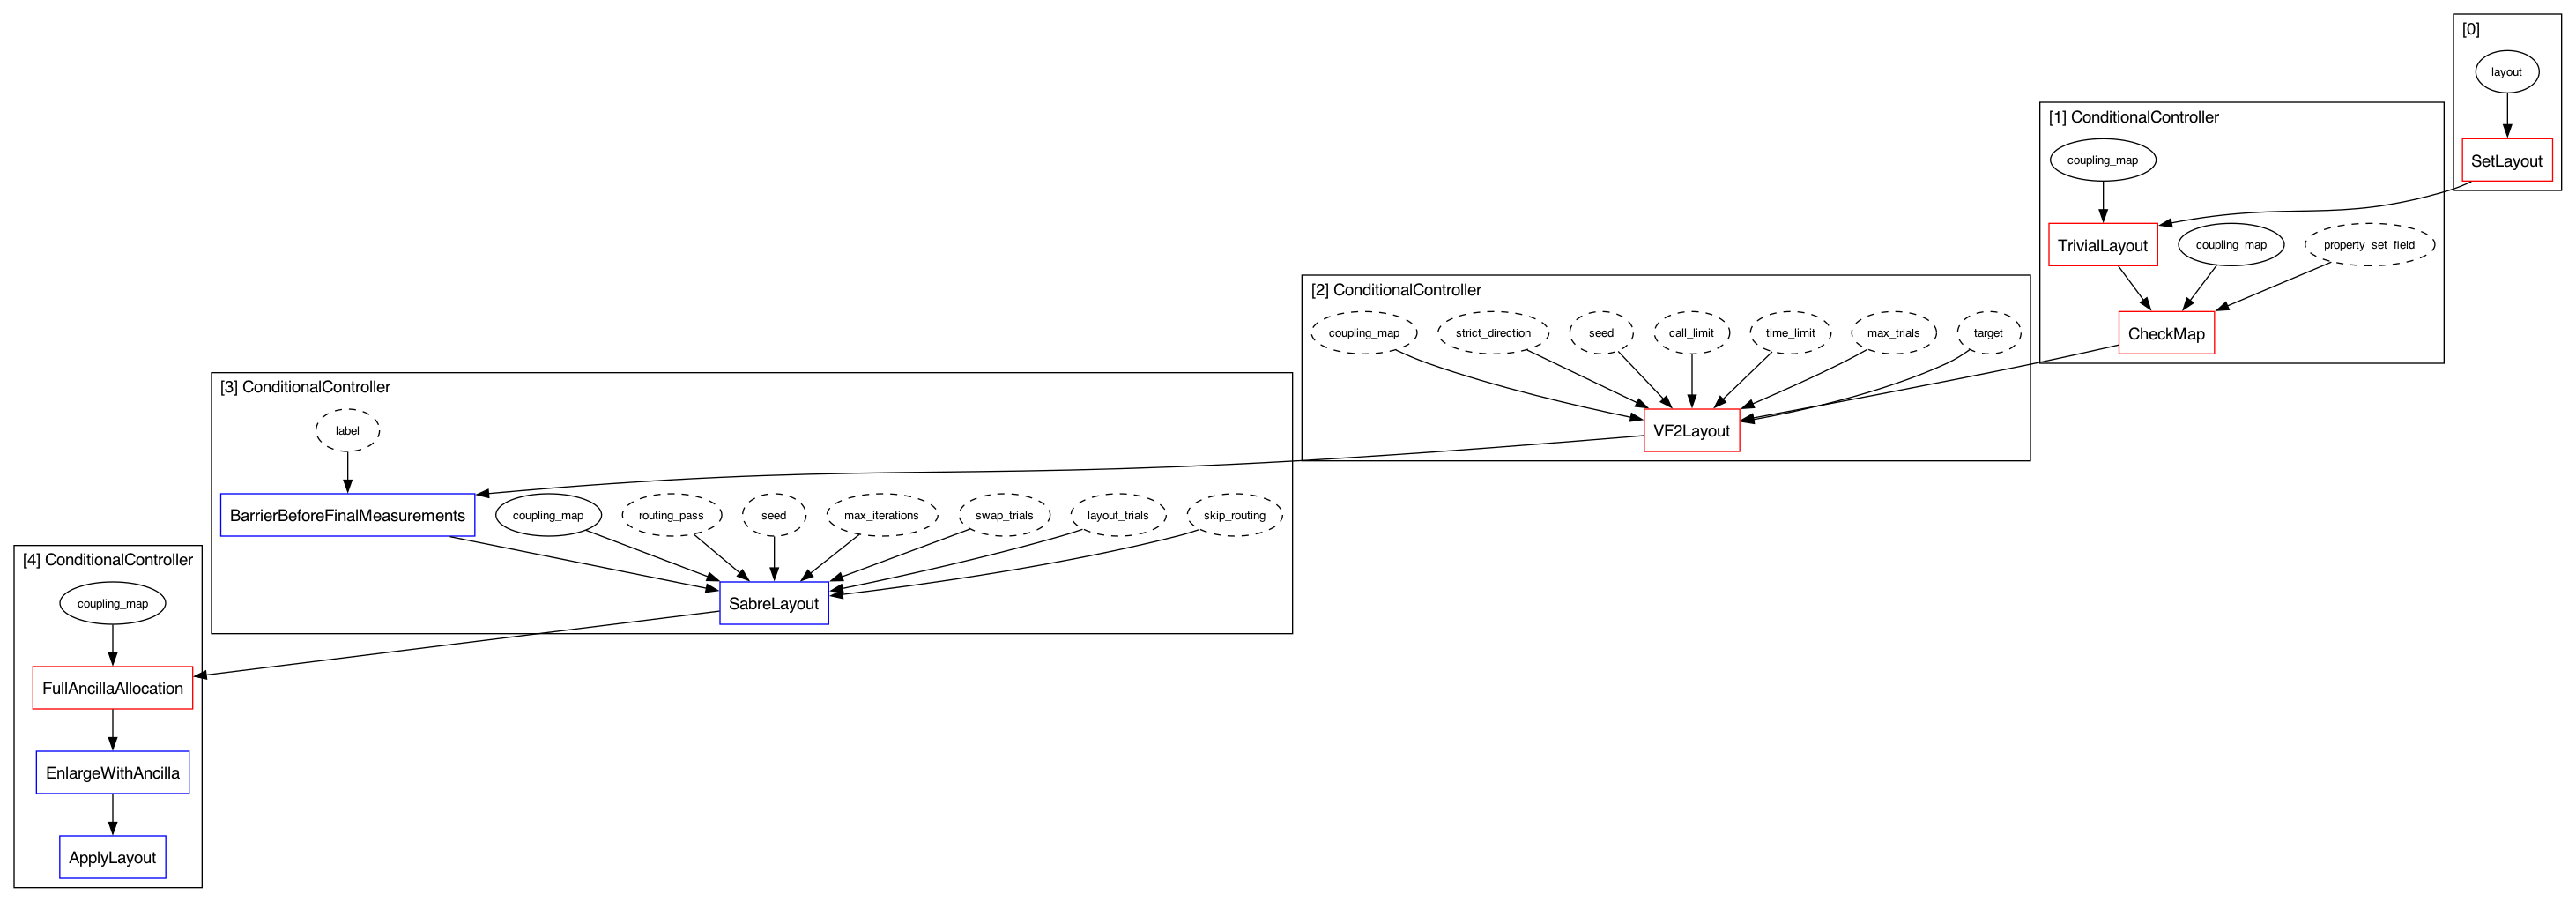

INFO:qiskit.passmanager.base_tasks:Pass: SetLayout - 0.00525 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: TrivialLayout - 0.03195 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CheckMap - 0.04673 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: VF2Layout - 0.48399 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BarrierBeforeFinalMeasurements - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: SabreLayout - 2.44880 (ms)


In [25]:
display(pm.layout.draw())
layout_out = pm.layout.run(init_out)
layout_out.draw("mpl", idle_wires=False, fold=-1)

`translation`ステージでも同様に実施してください。

**解答例:**



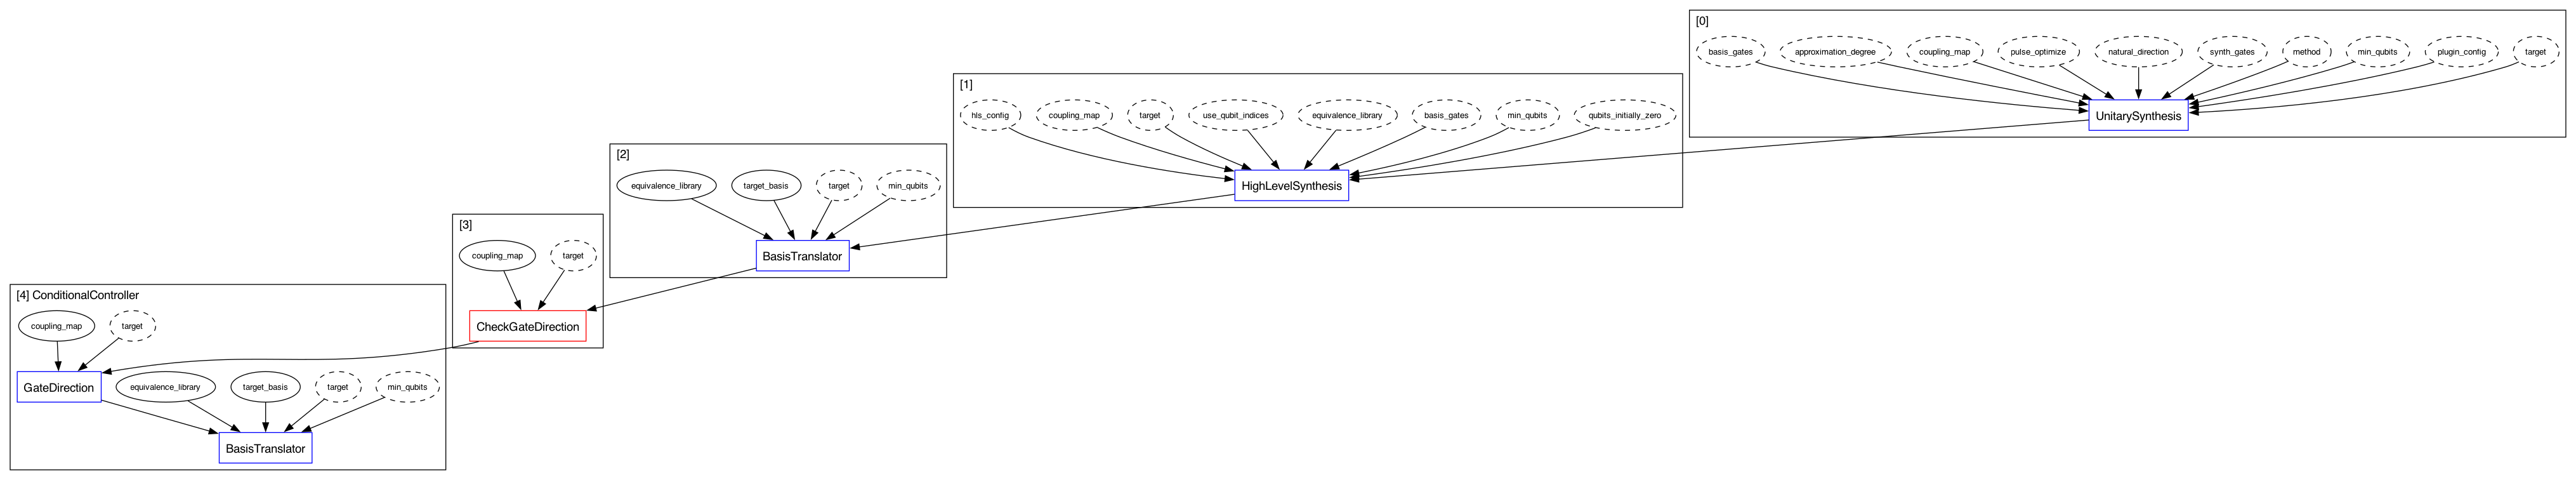

INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.11706 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 1.09696 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CheckGateDirection - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GateDirection - 0.09918 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.42319 (ms)


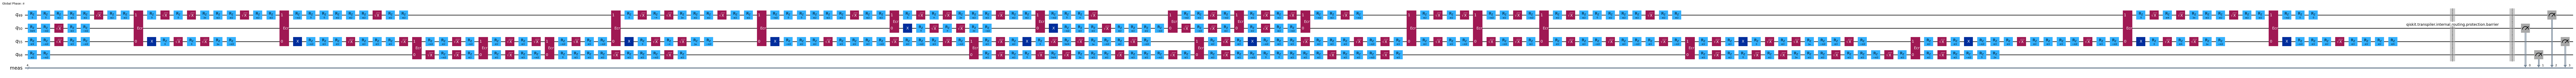

In [26]:
display(pm.translation.draw())
basis_out = pm.translation.run(layout_out)
basis_out.draw("mpl", idle_wires=False, fold=-1)

注：各ステージは必ずしも独立して実行できるわけではありません（前のステージから情報を引き継ぐ必要がある場合があります）。



### 3.4 最適化ステージ

パイプラインの最後のデフォルトステージは最適化です。ターゲット用に回路を埋め込んだ後、回路はかなり膨らみます。これは主に基底変換やSWAP挿入による非効率性が原因です。最適化ステージでは、回路のサイズや深さを最小化するために一連のパスを`do while`ループで実行し、出力が安定するまで繰り返します。



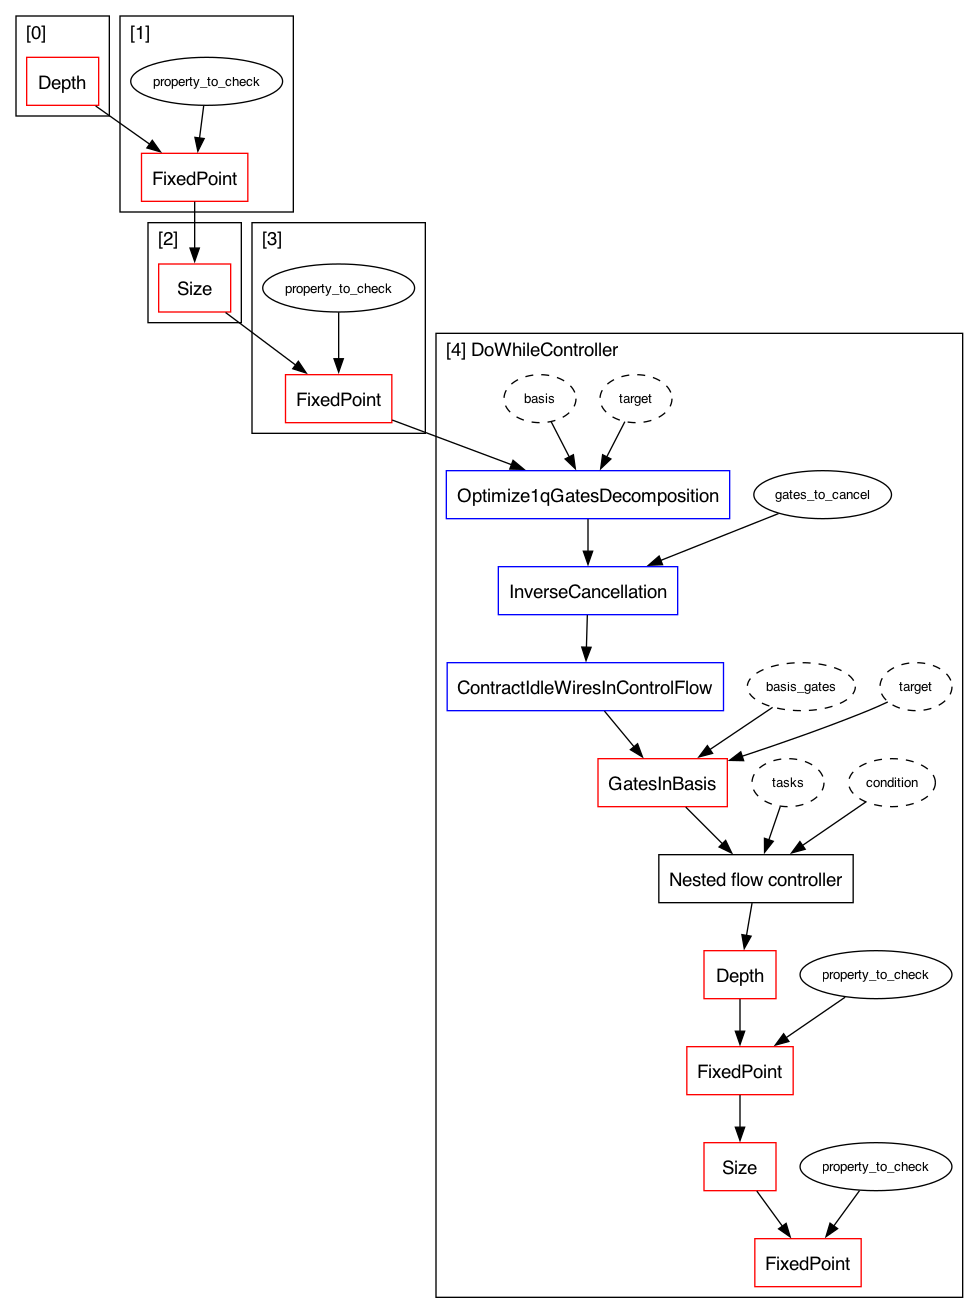

In [27]:
# pm.pre_optimization.draw()
pm.optimization.draw()

In [28]:
logger = logging.getLogger()
logger.setLevel("INFO")
opt_out = pm.optimization.run(basis_out)

INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.04721 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00691 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.26321 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.29802 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContractIdleWiresInControlFlow - 0.00811 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 0.03695 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00691 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.00691 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00501 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 0.13399 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.08392 (ms)
INFO:qis

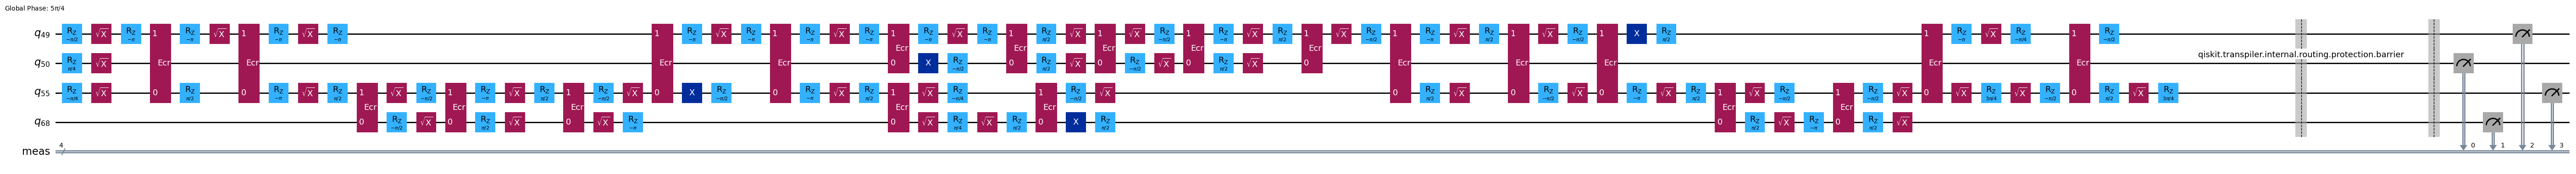

In [29]:
opt_out.draw("mpl", idle_wires=False, fold=-1)

## 4. 詳細な例

### 4.1 2量子ビットブロック最適化（2量子ビットユニタリー合成）

レベル2・3では、より多くのパス（`Collect2qBlocks`, `ConsolidateBlocks`, `UnitarySynthesis`）による最適化、すなわち2量子ビットブロック最適化が行われます。（レベル1の最適化ステージと比較してください）

2量子ビットブロック最適化は、2量子ビットブロックの収集・統合と、2量子ビットユニタリ行列の合成の2ステップで構成されます。



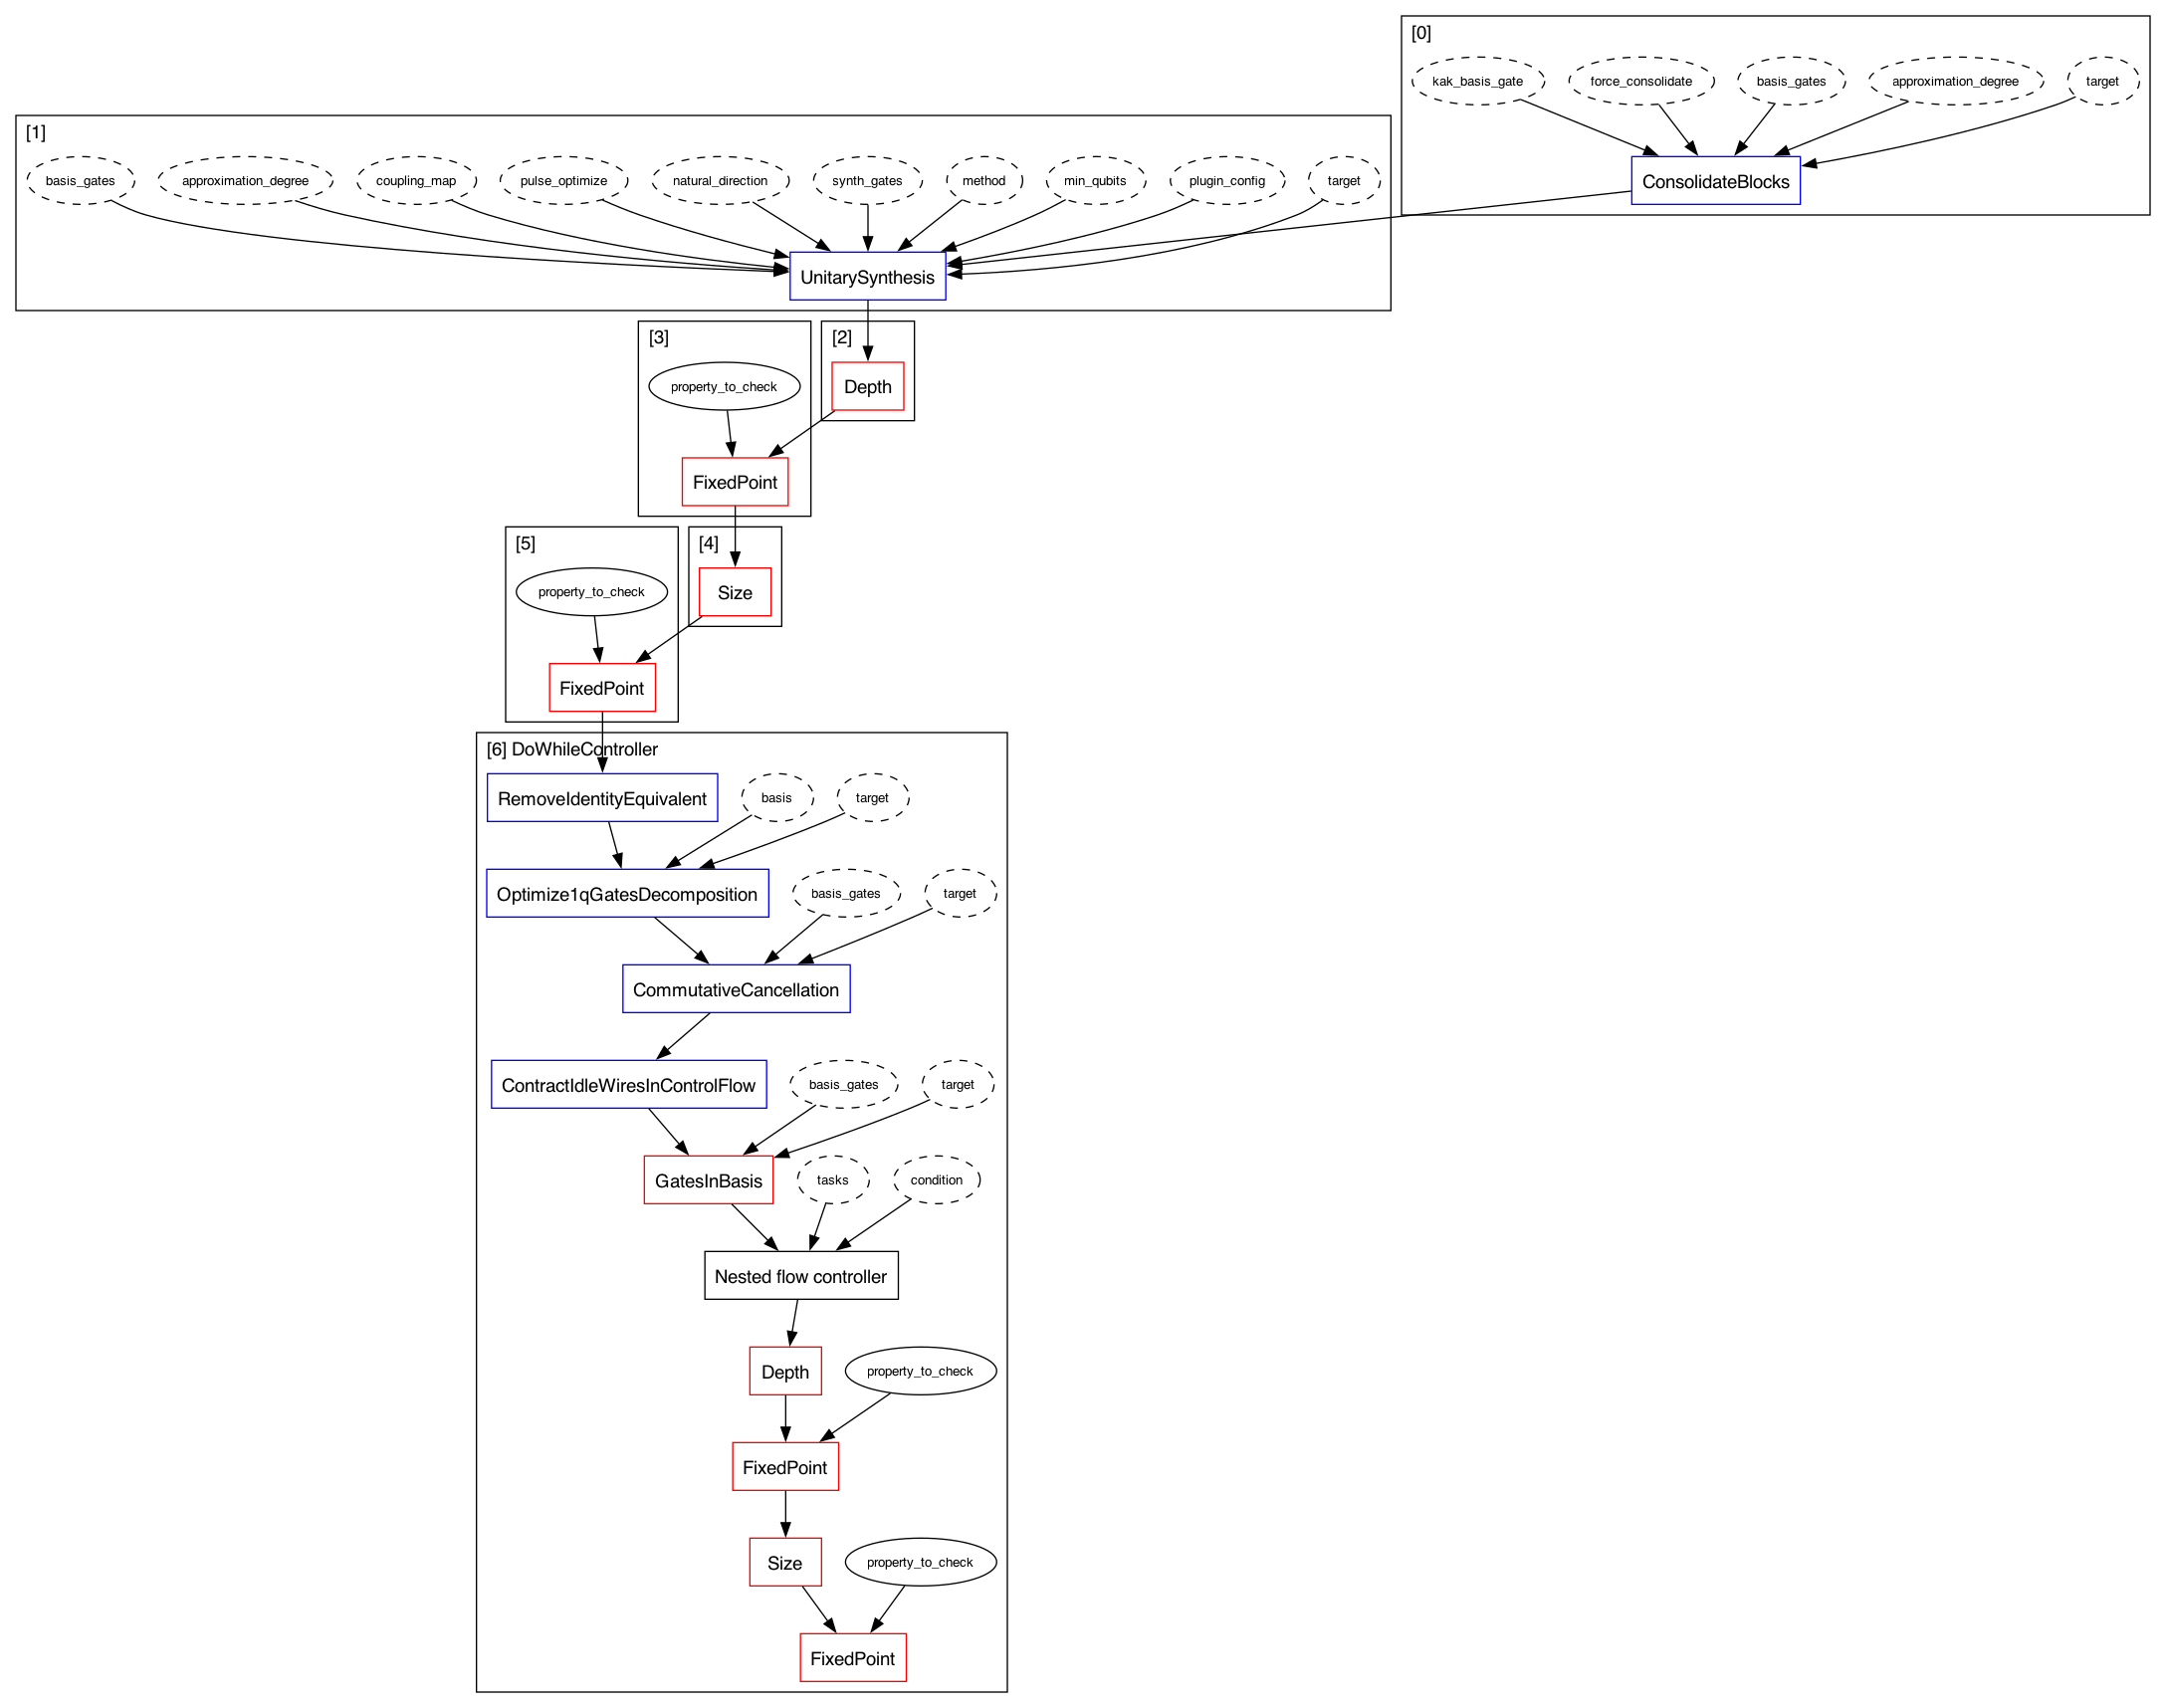

In [30]:
pm2 = generate_preset_pass_manager(2, backend, seed_transpiler=42)
pm2.optimization.draw()

In [31]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
)

# Collect 2q blocks and consolidate to unitary when we expect that we can reduce the 2q gate count for that unitary
consolidate_pm = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(target=backend.target),
    ]
)

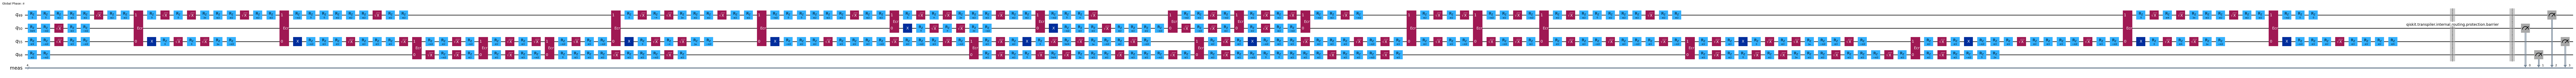

INFO:qiskit.passmanager.base_tasks:Pass: Collect2qBlocks - 0.06080 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 0.16904 (ms)


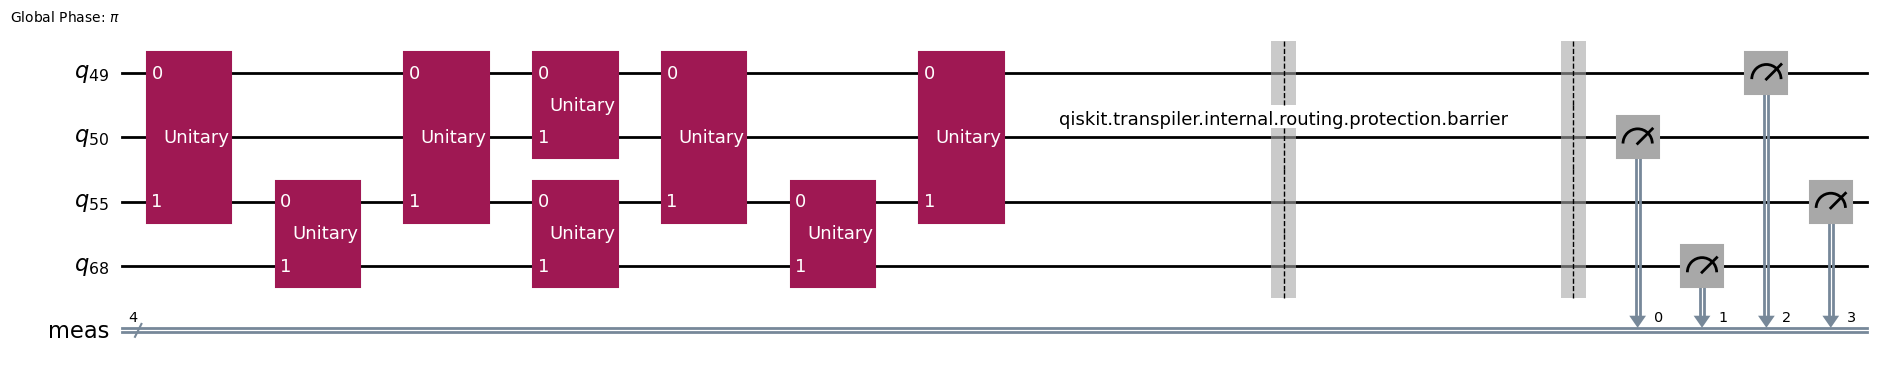

In [32]:
display(basis_out.draw("mpl", idle_wires=False, fold=-1))

consolidated = consolidate_pm.run(basis_out)
consolidated.draw("mpl", idle_wires=False, fold=-1)

In [33]:
# Synthesize unitaries
UnitarySynthesis(target=backend.target)(consolidated).draw(
    "mpl", idle_wires=False, fold=-1
)

INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.74816 (ms)


In [34]:
logger.setLevel("WARNING")

パート2で見たように、実際の量子コンパイラのフローは非常に多くのパス（タスク）で構成されています。これは、幅広い応用回路に対する性能やソフトウェアの保守性を確保するためのソフトウェア工学的な理由によるものです。Qiskitトランスパイラは多くの場合うまく動作しますが、もし自分の回路が十分に最適化されない場合は、パート1で示したような応用特化型の回路最適化を研究する良い機会です。トランスパイラ技術は進化中ですので、皆さんのR&Dの貢献も歓迎します。



In [35]:
from qiskit.circuit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

In [37]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
sampler = Sampler(backend)

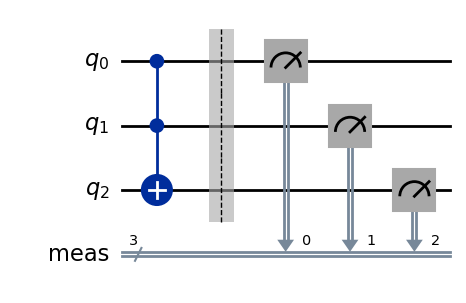

In [38]:
circ = QuantumCircuit(3)
circ.ccx(0, 1, 2)
circ.measure_all()
circ.draw("mpl")

In [39]:
sampler.run([circ])  # IBMInputValueError will be raised

IBMInputValueError: 'The instruction ccx on qubits (0, 1, 2) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://quantum.cloud.ibm.com/docs/guides/transpile) for instructions to transform circuits and the primitive examples (https://quantum.cloud.ibm.com/docs/guides/primitives-examples) to see this coupled with operator transformations.'

### 4.2 回路最適化の重要性

まず、最適化あり・なしで5量子ビットGHZ状態（$\frac{1}{\sqrt{2}} \left( |00000\rangle + |11111\rangle \right)$）生成回路の実行結果を比較します。



In [40]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

In [41]:
service = QiskitRuntimeService()

In [ ]:
# backend = service.backend('ibm_brisbane')
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)  # Eagle
backend

<IBMBackend('ibm_brisbane')>

まず、以下のように素朴に合成したGHZ回路を使います。



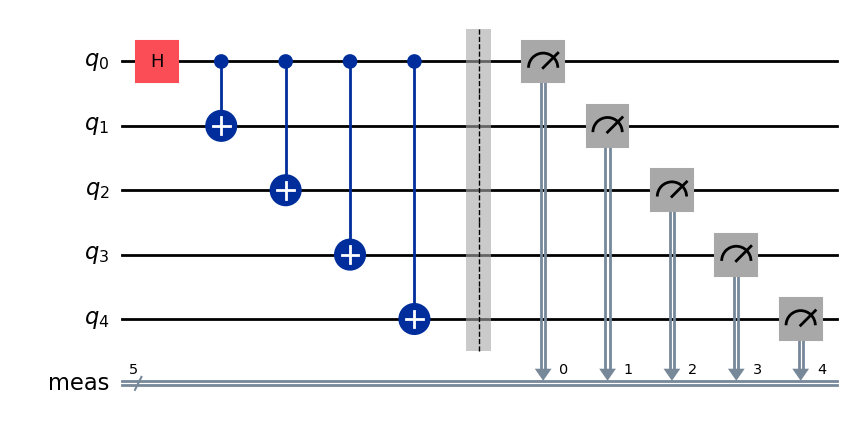

In [43]:
num_qubits = 5

ghz_circ = QuantumCircuit(num_qubits)
ghz_circ.h(0)
[ghz_circ.cx(0, i) for i in range(1, num_qubits)]
ghz_circ.measure_all()
ghz_circ.draw("mpl")

回路を最適化なし（`optimization_level=0`）と最適化あり（`optimization_level=2`）でトランスパイルします。
ご覧の通り、トランスパイル後の回路長に大きな違いがあります。



In [44]:
pm0 = generate_preset_pass_manager(
    optimization_level=0, backend=backend, seed_transpiler=777
)
pm2 = generate_preset_pass_manager(
    optimization_level=2, backend=backend, seed_transpiler=777
)
circ0 = pm0.run(ghz_circ)
circ2 = pm2.run(ghz_circ)
print("optimization_level=0:")
display(circ0.draw("mpl", idle_wires=False, fold=-1))
print("optimization_level=2:")
display(circ2.draw("mpl", idle_wires=False, fold=-1))

optimization_level=0:


optimization_level=2:


In [45]:
# run the circuits
sampler = Sampler(backend)
job = sampler.run([circ0, circ2], shots=10000)
job_id = job.job_id()
print(f"Job ID: {job_id}")

Job ID: d2g4kil0d2ps738vn0jg


In [46]:
# REPLACE WITH YOUR OWN JOB IDS
job = service.job(job_id)

In [47]:
# get results
result = job.result()
unoptimized_result = result[0].data.meas.get_counts()
optimized_result = result[1].data.meas.get_counts()

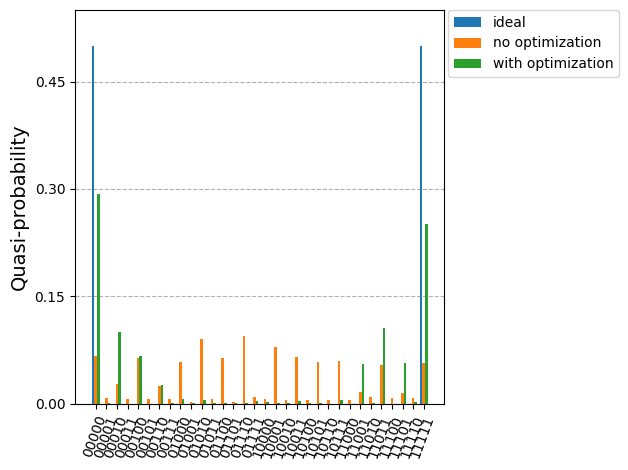

In [48]:
from qiskit.visualization import plot_histogram

# plot
sim_result = {"0" * 5: 0.5, "1" * 5: 0.5}
plot_histogram(
    [result for result in [sim_result, unoptimized_result, optimized_result]],
    bar_labels=False,
    legend=[
        "ideal",
        "no optimization",
        "with optimization",
    ],
)

### 4.3 回路合成の重要性



次に、2通りの合成方法で作った5量子ビットGHZ状態（$\frac{1}{\sqrt{2}} \left( |00000\rangle + |11111\rangle \right)$）生成回路の実行結果を比較します。



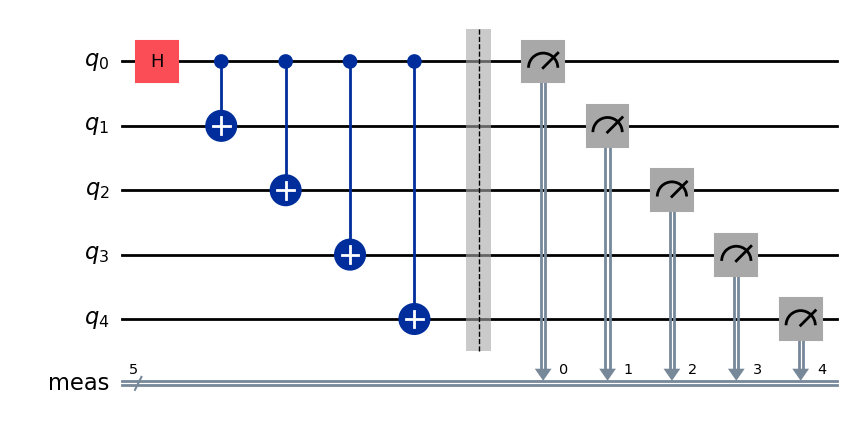

In [49]:
# Original GHZ circuit (naive synthesis)
ghz_circ.draw("mpl")

In [50]:
# A better GHZ circuit (smarter synthesis), you learned in a previous lecture
ghz_circ2 = QuantumCircuit(5)
ghz_circ2.h(2)
ghz_circ2.cx(2, 1)
ghz_circ2.cx(2, 3)
ghz_circ2.cx(1, 0)
ghz_circ2.cx(3, 4)
ghz_circ2.measure_all()
ghz_circ2.draw("mpl")

original synthesis:


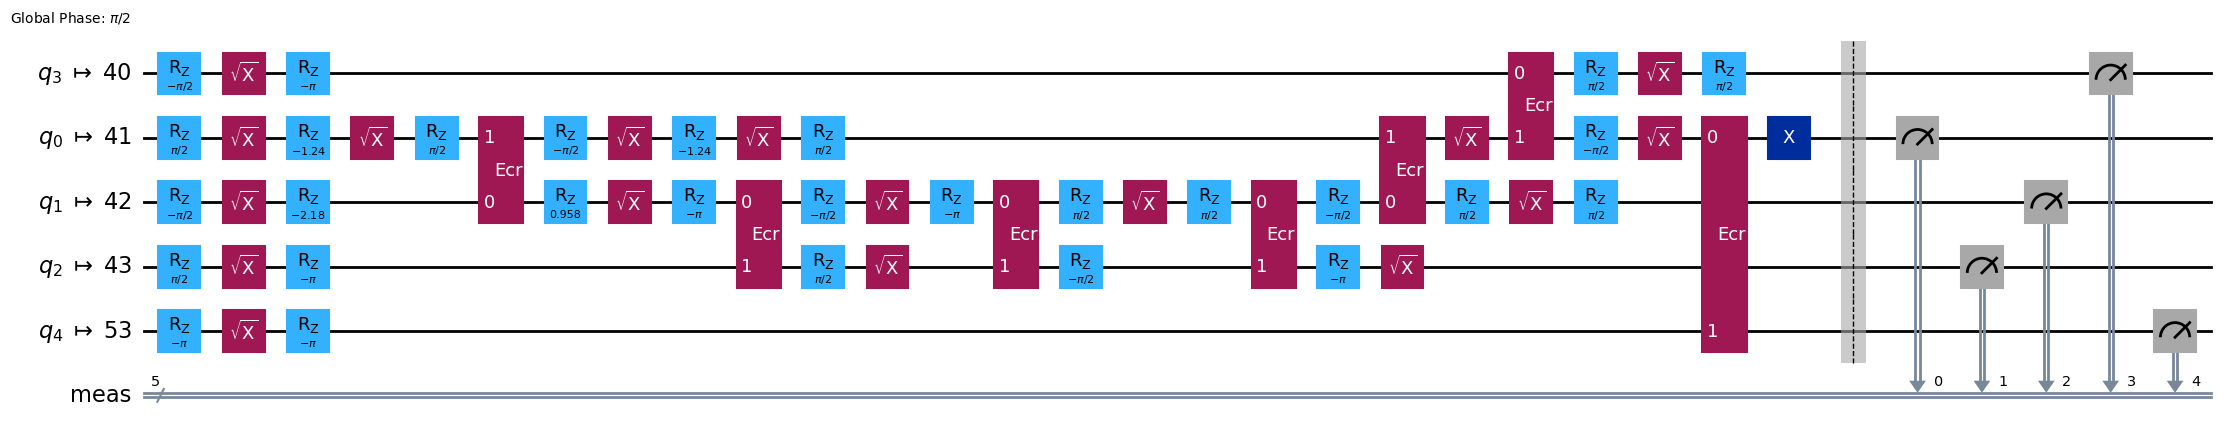

new synthesis:


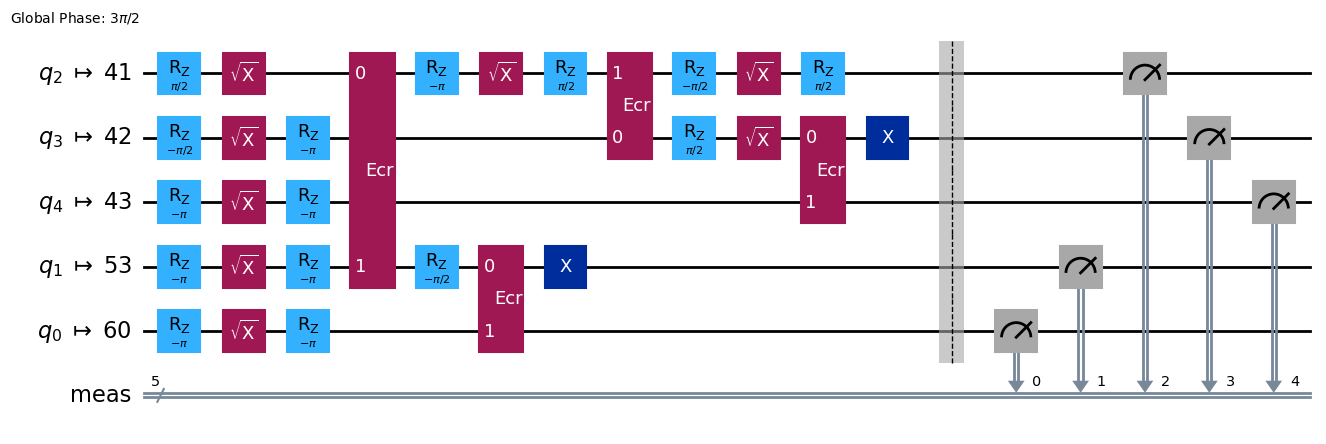

In [51]:
circ_org = pm2.run(ghz_circ)
circ_new = pm2.run(ghz_circ2)
print("original synthesis:")
display(circ_org.draw("mpl", idle_wires=False, fold=-1))
print("new synthesis:")
display(circ_new.draw("mpl", idle_wires=False, fold=-1))

In [52]:
# run the circuits
sampler = Sampler(backend)
job = sampler.run([circ_org, circ_new], shots=10000)
job_id = job.job_id()
print(f"Job ID: {job_id}")

Job ID: d2g4kqt0d2ps738vn0r0


In [53]:
# REPLACE WITH YOUR OWN JOB IDS
job = service.job(job_id)

In [54]:
# get results
result = job.result()
synthesis_org_result = result[0].data.meas.get_counts()
synthesis_new_result = result[1].data.meas.get_counts()

In [55]:
# plot
sim_result = {"0" * 5: 0.5, "1" * 5: 0.5}
plot_histogram(
    [result for result in [sim_result, synthesis_org_result, synthesis_new_result]],
    bar_labels=False,
    legend=[
        "ideal",
        "synthesis_org",
        "synthesis_new",
    ],
)

### 4.4 一般的な1量子ビットゲート分解



In [56]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import UGate

phi, theta, lam = Parameter("φ"), Parameter("θ"), Parameter("λ")

In [57]:
qc = QuantumCircuit(1)
qc.append(UGate(theta, phi, lam), [0])
qc.draw(output="mpl")

In [58]:
transpile(qc, basis_gates=["rz", "sx"]).draw(output="mpl")

### 4.5 1量子ビットブロック最適化



In [59]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(1)
qc.x(0)
qc.y(0)
qc.z(0)
qc.rx(1.23, 0)
qc.ry(1.23, 0)
qc.rz(1.23, 0)
qc.h(0)
qc.s(0)
qc.t(0)
qc.sx(0)
qc.sdg(0)
qc.tdg(0)
qc.draw(output="mpl")

In [60]:
from qiskit.quantum_info import Operator

Operator(qc)

Operator([[ 0.45292511-0.57266982j, -0.66852684-0.14135058j],
          [ 0.14135058+0.66852684j, -0.57266982+0.45292511j]],
         input_dims=(2,), output_dims=(2,))


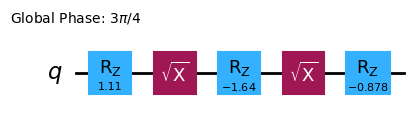

In [61]:
from qiskit import transpile

qc_opt = transpile(qc, basis_gates=["rz", "sx"])
qc_opt.draw(output="mpl")

In [62]:
Operator(qc_opt)

Operator([[ 0.45292511-0.57266982j, -0.66852684-0.14135058j],
          [ 0.14135058+0.66852684j, -0.57266982+0.45292511j]],
         input_dims=(2,), output_dims=(2,))


In [63]:
Operator(qc).equiv(Operator(qc_opt))

True

### 4.6 トフォリ分解



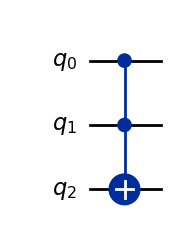

In [64]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.draw(output="mpl")

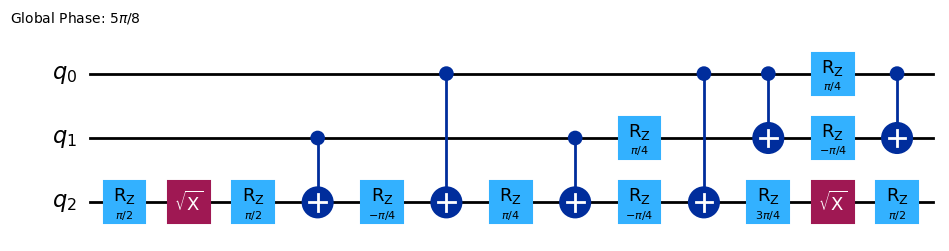

In [65]:
from qiskit import QuantumCircuit, transpile

qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc = transpile(qc, basis_gates=["rz", "sx", "cx"])
qc.draw(output="mpl")

### 4.7 CUゲート分解



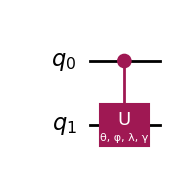

In [66]:
from qiskit.circuit.library.standard_gates import CUGate

phi, theta, lam, gamma = Parameter("φ"), Parameter("θ"), Parameter("λ"), Parameter("γ")
qc = QuantumCircuit(2)
# qc.cu(theta, phi, lam, gamma, 0, 1)
qc.append(CUGate(theta, phi, lam, gamma), [0, 1])
qc.draw(output="mpl")

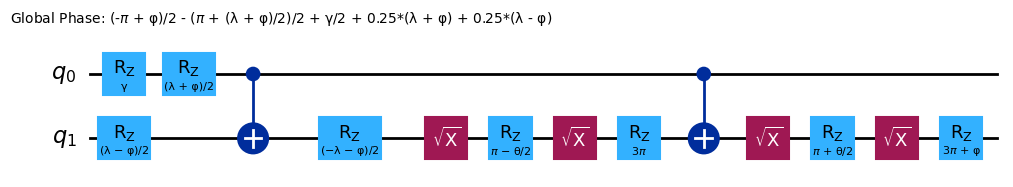

In [67]:
from qiskit.circuit.library.standard_gates import CUGate

phi, theta, lam, gamma = Parameter("φ"), Parameter("θ"), Parameter("λ"), Parameter("γ")
qc = QuantumCircuit(2)
qc.append(CUGate(theta, phi, lam, gamma), [0, 1])
qc = transpile(qc, basis_gates=["rz", "sx", "cx"])
qc.draw(output="mpl")

### 4.8 CX, ECR, CZはローカルClifford変換で等価

$H$(アダマール)、$S$（$\pi/2$ Z回転）、$S^\dagger$（$-\pi/2$ Z回転）、$X$（パウリX）はすべてCliffordゲートです。



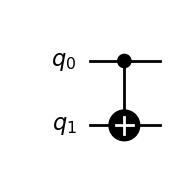

In [68]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.draw(output="mpl", style="bw")

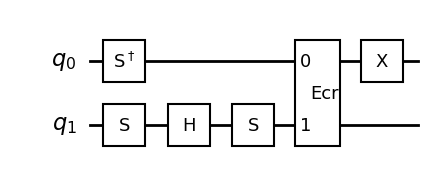

In [69]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
transpile(qc, basis_gates=["x", "s", "h", "sdg", "ecr"]).draw(output="mpl", style="bw")

In [70]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
transpile(qc, basis_gates=["h", "cz"]).draw(output="mpl", style="bw")

IBMバックエンドの1量子ビット基底ゲート「rz」「sx」「x」を使用します。



In [71]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
transpile(qc, basis_gates=["rz", "sx", "x", "ecr"]).draw(output="mpl", style="bw")

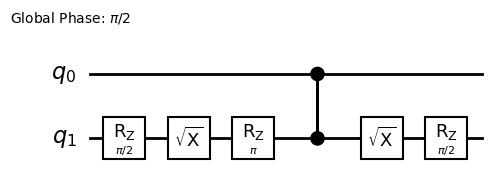

In [72]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
transpile(qc, basis_gates=["rz", "sx", "x", "cz"]).draw(output="mpl", style="bw")

In [73]:
# Check Qiskit version
import qiskit

qiskit.__version__

'2.1.1'

© IBM Corp., 2017-2025